- Tensorflow dataset
- Simple LSTM Network
- Long sequences to short chunks

In [1]:
! pip install pandas

    100% |████████████████████████████████| 10.0MB 3.0MB/s ta 0:00:01
    100% |████████████████████████████████| 512kB 3.7MB/s ta 0:00:011
You are using pip version 19.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
! pip install mne

    100% |████████████████████████████████| 6.6MB 2.1MB/s ta 0:00:01
    100% |████████████████████████████████| 26.0MB 715kB/s ta 0:00:011
You are using pip version 19.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
! pip install scikit-learn

    100% |████████████████████████████████| 7.0MB 3.2MB/s eta 0:00:01    59% |███████████████████             | 4.2MB 5.8MB/s eta 0:00:01
    100% |████████████████████████████████| 296kB 12.3MB/s ta 0:00:01
You are using pip version 19.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
! pip install seaborn

    100% |████████████████████████████████| 225kB 3.3MB/s ta 0:00:01
You are using pip version 19.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
! pip install keras

    100% |████████████████████████████████| 378kB 6.9MB/s ta 0:00:01
    100% |████████████████████████████████| 276kB 12.0MB/s ta 0:00:01
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built pyyaml
You are using pip version 19.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
! pip install tqdm

    100% |████████████████████████████████| 61kB 876kB/s ta 0:00:011
You are using pip version 19.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import tensorflow as tf

In [2]:
import numpy as np

In [3]:
import pandas as pd

In [4]:
import mne

In [5]:
import os

In [6]:
import keras

Using TensorFlow backend.


In [7]:
import seaborn as sns

In [8]:
from collections import Counter

In [9]:
from tqdm import tqdm_notebook

In [10]:
from tqdm.notebook import tqdm

Какие каналы содержат 

Dataset:
- Один сэмпл содержит чанк сигнала, чанки не пересекаются
- Считывание происходит из случайных файлов из списка
- Чанки рандомизированы:
    - Учесть рандомизацию по номеру пациента, сессии, времени

# Read labels

In [11]:
header = ["file", "start", "end", "label", "confidence"]
train_df = pd.read_csv("../_DOCS/ref_train.txt", sep=" ", names=header)
val_df = pd.read_csv("../_DOCS/ref_dev.txt", sep=" ", names=header)

In [12]:
def preprocess_file(full_file):
    parts = full_file.split("_")
    patient = int(parts[0])
    session = int(parts[1][1:])
    file = int(parts[2][1:])
    return [patient, session, file]

In [13]:
preprocess_file("00000258_s002_t000")

[258, 2, 0]

In [14]:
def append_file_info(df):
    values = np.array(df["file"].apply(preprocess_file).tolist())
    files_df = pd.DataFrame(values, columns=["patient", "session", "chunk"], index=df.index)
    return df.merge(files_df, how="inner", left_index=True, right_index=True)

In [15]:
train_df = append_file_info(train_df)

In [16]:
val_df = append_file_info(val_df)

# Attach files

TODO add other electrode formats

In [17]:
def attach_files(df, dataset):
    paths = {}

    for root, dirs, files in os.walk("../edf/{}".format(dataset)):
        path = root.split(os.sep)
        for file in files:
            if ".edf" in file:
                name = file.split(".")[0]
                paths[name] = os.path.abspath(root) + "/" +  file
    
    df["full_path"] = df["file"].apply(paths.get)
    return df[df["full_path"].apply(lambda x: "01_tcp_ar" in x)].copy()

In [18]:
train_df = attach_files(train_df, "train")

In [19]:
val_df = attach_files(val_df, "dev")

# Remove bckg files

In [20]:
def remove_bckg_files(df):
    files_with_seizures = df[df["label"] == "seiz"]["file"].unique()
    return df[df["file"].isin(files_with_seizures)].copy()

In [21]:
train_df = remove_bckg_files(train_df)

In [22]:
val_df = remove_bckg_files(val_df)

# Calculate channels intersection and proper sample rate

In [23]:
def get_edf_info(df):
    files = df["full_path"].unique()

    edf_data = []

    for file in tqdm_notebook(files):
        edf = mne.io.read_raw_edf(file, verbose="ERROR")
        data = {
            field: edf.info[field]
            for field in ["ch_names", "sfreq"]
        }
        edf_data.append(data)
        
    return pd.DataFrame(edf_data)

In [24]:
train_edf_df = get_edf_info(train_df)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [25]:
val_edf_df = get_edf_info(val_df)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [26]:
CHUNK_FREQUENCY = int(min(train_edf_df["sfreq"].min(), val_edf_df["sfreq"].min()))

In [27]:
counter = Counter([
    channel for channels_list in train_edf_df["ch_names"] for channel in channels_list
] + [
    channel for channels_list in val_edf_df["ch_names"] for channel in channels_list
])

In [28]:
all_channels = dict(counter.most_common())

In [29]:
usage_limit = max([v for k, v in all_channels.items() if "STI" not in k])
CHANNELS = [k for k, v in all_channels.items() if v >= usage_limit and "STI" not in k]

In [30]:
# STIM_CHANNEL = [k for k in all_channels.keys() if "STI" in k][0]

In [31]:
len(CHANNELS)

21

# Calculate chunk size

In [32]:
train_df["duration"] = train_df["end"] - train_df["start"]

label
bckg    AxesSubplot(0.125,0.125;0.775x0.755)
seiz    AxesSubplot(0.125,0.125;0.775x0.755)
Name: duration, dtype: object

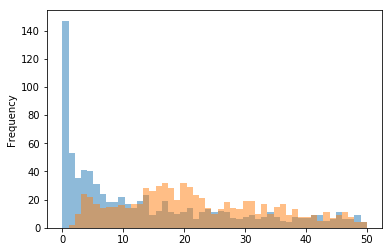

In [33]:
train_df.groupby('label')["duration"].plot(kind="hist", bins=np.linspace(0, 50), alpha=0.5)

In [34]:
CHUNK_TIME = 1 * CHUNK_FREQUENCY # number of terms per chunk

# Split on chunks

In [35]:
BATCH_SIZE = 32

- Get all file names, randomize them
- For each file - split on chunks, randomize them
- Get labels for each chunk

In [128]:
def get_fourier_transform(data, window_size=CHUNK_TIME, step_size=CHUNK_TIME // 10):
    data = data.T
    frequencies = []
    for window in range(0, data.shape[0] - window_size, step_size):
        chunk = data[window:window + window_size]
        frequency_values = np.abs(np.fft.fft(chunk, axis=0))[:window_size // 2]
        frequencies.append(frequency_values)
    result = np.stack(frequencies)
    return result.reshape(result.shape[0], -1).T

In [129]:
def get_data(df, file, channels=CHANNELS, chunk_size=CHUNK_TIME):
    annotations = df[
        (df["full_path"] == file) & \
        (df["label"] == "seiz")
    ][["start", "end"]]
    edf = mne.io.read_raw_edf(file, preload=True, verbose='ERROR')
    edf.filter(2, 60)
    edf_picks = edf.pick_channels(channels)
    data, time = edf_picks[:]
        
    events = time * 0
    for _, (start, end) in annotations.iterrows():
        events += (time >= start) & (time <= end)
    events = (events > 0).astype(int)
    
    return data, events

In [130]:
def get_data_multiple(df, files, channels=CHANNELS, chunk_size=CHUNK_TIME):
    total_data = []
    total_events = []
    for file in tqdm_notebook(files):
        data, events = get_data(df, file)
        total_data.append(data)
        total_events.append(events)
    
    min_length = min([e.shape[0] for e in total_events])
    truncated_length = (min_length // chunk_size) * chunk_size
    total_data = [d[:, :truncated_length] for d in total_data]
    total_events = [e[:truncated_length] for e in total_events]
    
    total_data = [
        get_fourier_transform(d)
        for d in total_data
    ]
    
    return np.stack(total_data), np.stack(total_events)

In [131]:
def iterate_chunks(data, events, chunk_size=CHUNK_TIME):
    max_time = max([e.shape[0] for e in events])
    while True:
        for chunk_start in range(0, max_time - chunk_size, chunk_size // 10):
            data_chunk = [d[:, chunk_start:chunk_start + chunk_size].T for d in data]

            labels_chunk = [e[chunk_start:chunk_start + chunk_size] for e in events]

            yield np.stack(data_chunk), np.stack(labels_chunk)[:, :, np.newaxis]

In [132]:
def iterate_files(df, batch_size=BATCH_SIZE):
    files = df["full_path"].unique()
    files = np.random.choice(files, len(files), replace=False)
    for files in zip(*[iter(files)]*batch_size):
        yield files

In [133]:
files = next(iterate_files(train_df))

In [134]:
data, events = get_data(train_df, files[0])

In [148]:
files = train_df["full_path"].value_counts().index[0:32]
data, events = get_data_multiple(train_df, files)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [147]:
data.shape

(21, 314500)

In [102]:
iterator = iterate_chunks(data, events)

In [103]:
data_chunk, labels_chunk = next(iterator)

In [104]:
data_chunk.shape

(32, 250, 2625)

Чанк для LSTM: (BATCH_SIZE x CHUNK_TIME x FREQUENCIES * CHANNELS)

# Model creation

In [135]:
RNN_SIZE = 128
NUM_EPOCHS = 10

In [136]:
CNN_FILTERS = (8, 16, 32, 128)

Можно ли добавить CNN?
- Conv1D: (BATCH_SIZE, CHUNK_TIME, CHANNELS) -> (BATCH_SIZE, CHUNK_TIME, CNN_FILTERS)
- MaxPool1D: (BATCH_SIZE, CHUNK_TIME, CNN_FILTERS) -> (BATCH_SIZE, CHUNK_TIME // POOL_SIZE, CNN_FILTERS)

Продолжать до тех пор, пока чанка не станет достаточного размера

In [137]:
import tensorflow as tf
from keras.layers import Dense,Activation,Dropout
from keras.layers import LSTM,Bidirectional #could try TimeDistributed(Dense(...))
from keras.models import Sequential, load_model
from keras import optimizers,regularizers
from keras.layers.normalization import BatchNormalization
import keras.backend.tensorflow_backend as KTF

In [155]:
model = Sequential()
model.add(Dense(32,W_regularizer=regularizers.l2(l=0.01), batch_input_shape=(BATCH_SIZE, CHUNK_TIME, CHUNK_TIME // 2 * len(CHANNELS))))
model.add(Bidirectional(LSTM(32, return_sequences=True, stateful=False)))#, input_shape=(seqlength, features)) ) ### bidirectional ---><---
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu',W_regularizer=regularizers.l2(l=0.01)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, batch_input_shape=(32, 250, ..., kernel_regularizer=<keras.reg...)`
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="relu", kernel_regularizer=<keras.reg...)`
  


In [156]:
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [157]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [158]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam', 
    metrics=['accuracy', recall_m, precision_m]
)

# Overfit on small dataset

- TODO add validation
- TODO make batch
- TODO speed up iteration

TODO make model converge on this batch

In [159]:
generator = iterate_chunks(data, events)

In [160]:
next(generator)
x, y_end = next(generator)

In [161]:
y_end.sum() / (y_end > -1).sum()

0.025125

In [162]:
model.predict(x)[3].mean()

0.5002788

In [163]:
model.evaluate(x, y_end)

32/32 [==============================] - 0s 11ms/step


[1.974715232849121, 0.06475000083446503, 1.0, 0.02616165578365326]

In [164]:
model.fit(x, y_end, batch_size=x.shape[0], epochs=1000)

Epoch 1/1000
32/32 [==============================] - 1s 28ms/step - loss: 2.0608 - accuracy: 0.6528 - recall_m: 0.2736 - precision_m: 0.0205
Epoch 2/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.0369 - accuracy: 0.4711 - recall_m: 0.7512 - precision_m: 0.0349
Epoch 3/1000
32/32 [==============================] - 0s 8ms/step - loss: 1.9833 - accuracy: 0.4689 - recall_m: 0.7612 - precision_m: 0.0351
Epoch 4/1000
32/32 [==============================] - 0s 8ms/step - loss: 1.9311 - accuracy: 0.5395 - recall_m: 0.7363 - precision_m: 0.0392
Epoch 5/1000
32/32 [==============================] - 0s 8ms/step - loss: 1.8939 - accuracy: 0.5828 - recall_m: 0.5970 - precision_m: 0.0355
Epoch 6/1000
32/32 [==============================] - 0s 8ms/step - loss: 1.8586 - accuracy: 0.6176 - recall_m: 0.4975 - precision_m: 0.0327
Epoch 7/1000
32/32 [==============================] - 0s 8ms/step - loss: 1.8087 - accuracy: 0.6364 - recall_m: 0.5323 - precision_m: 0.0366
Epoch 8/1000

Epoch 59/1000
32/32 [==============================] - 0s 9ms/step - loss: 0.7163 - accuracy: 0.9615 - recall_m: 0.7164 - precision_m: 0.3646
Epoch 60/1000
32/32 [==============================] - 0s 8ms/step - loss: 0.7058 - accuracy: 0.9609 - recall_m: 0.7114 - precision_m: 0.3593
Epoch 61/1000
32/32 [==============================] - 0s 9ms/step - loss: 0.6954 - accuracy: 0.9589 - recall_m: 0.7065 - precision_m: 0.3447
Epoch 62/1000
32/32 [==============================] - 0s 8ms/step - loss: 0.6844 - accuracy: 0.9603 - recall_m: 0.7264 - precision_m: 0.3570
Epoch 63/1000
32/32 [==============================] - 0s 9ms/step - loss: 0.6744 - accuracy: 0.9613 - recall_m: 0.7363 - precision_m: 0.3654
Epoch 64/1000
32/32 [==============================] - 0s 9ms/step - loss: 0.6652 - accuracy: 0.9619 - recall_m: 0.6318 - precision_m: 0.3547
Epoch 65/1000
32/32 [==============================] - 0s 8ms/step - loss: 0.6550 - accuracy: 0.9592 - recall_m: 0.7711 - precision_m: 0.3563
Epoch 

Epoch 117/1000
32/32 [==============================] - 0s 9ms/step - loss: 0.2978 - accuracy: 0.9775 - recall_m: 0.5522 - precision_m: 0.5522
Epoch 118/1000
32/32 [==============================] - 0s 9ms/step - loss: 0.2947 - accuracy: 0.9772 - recall_m: 0.4826 - precision_m: 0.5543
Epoch 119/1000
32/32 [==============================] - 0s 8ms/step - loss: 0.2900 - accuracy: 0.9794 - recall_m: 0.3483 - precision_m: 0.6731
Epoch 120/1000
32/32 [==============================] - 0s 9ms/step - loss: 0.2858 - accuracy: 0.9779 - recall_m: 0.3682 - precision_m: 0.5968
Epoch 121/1000
32/32 [==============================] - 0s 8ms/step - loss: 0.2813 - accuracy: 0.9780 - recall_m: 0.5025 - precision_m: 0.5706
Epoch 122/1000
32/32 [==============================] - 0s 9ms/step - loss: 0.2775 - accuracy: 0.9776 - recall_m: 0.4229 - precision_m: 0.5743
Epoch 123/1000
32/32 [==============================] - 0s 9ms/step - loss: 0.2743 - accuracy: 0.9789 - recall_m: 0.3632 - precision_m: 0.6404

Epoch 175/1000
32/32 [==============================] - 0s 9ms/step - loss: 0.1460 - accuracy: 0.9797 - recall_m: 0.4478 - precision_m: 0.6383
Epoch 176/1000
32/32 [==============================] - 0s 10ms/step - loss: 0.1513 - accuracy: 0.9786 - recall_m: 0.2388 - precision_m: 0.7273
Epoch 177/1000
32/32 [==============================] - 0s 9ms/step - loss: 0.1459 - accuracy: 0.9797 - recall_m: 0.2537 - precision_m: 0.8095
Epoch 178/1000
32/32 [==============================] - 0s 8ms/step - loss: 0.1410 - accuracy: 0.9808 - recall_m: 0.4279 - precision_m: 0.6880
Epoch 179/1000
32/32 [==============================] - 0s 8ms/step - loss: 0.1389 - accuracy: 0.9769 - recall_m: 0.5871 - precision_m: 0.5364
Epoch 180/1000
32/32 [==============================] - 0s 8ms/step - loss: 0.1380 - accuracy: 0.9785 - recall_m: 0.6368 - precision_m: 0.5639
Epoch 181/1000
32/32 [==============================] - 0s 8ms/step - loss: 0.1399 - accuracy: 0.9775 - recall_m: 0.4677 - precision_m: 0.562

Epoch 233/1000
32/32 [==============================] - 0s 9ms/step - loss: 0.0981 - accuracy: 0.9775 - recall_m: 0.2935 - precision_m: 0.6082
Epoch 234/1000
32/32 [==============================] - 0s 9ms/step - loss: 0.0991 - accuracy: 0.9778 - recall_m: 0.2537 - precision_m: 0.6456
Epoch 235/1000
32/32 [==============================] - 0s 9ms/step - loss: 0.0966 - accuracy: 0.9779 - recall_m: 0.2438 - precision_m: 0.6622
Epoch 236/1000
32/32 [==============================] - 0s 8ms/step - loss: 0.0929 - accuracy: 0.9794 - recall_m: 0.3333 - precision_m: 0.6837
Epoch 237/1000
32/32 [==============================] - 0s 8ms/step - loss: 0.0915 - accuracy: 0.9796 - recall_m: 0.5373 - precision_m: 0.6067
Epoch 238/1000
32/32 [==============================] - 0s 8ms/step - loss: 0.0931 - accuracy: 0.9768 - recall_m: 0.5522 - precision_m: 0.5362
Epoch 239/1000
32/32 [==============================] - 0s 8ms/step - loss: 0.0924 - accuracy: 0.9775 - recall_m: 0.4279 - precision_m: 0.5695

Epoch 291/1000
32/32 [==============================] - 0s 8ms/step - loss: 0.0704 - accuracy: 0.9816 - recall_m: 0.6070 - precision_m: 0.6421
Epoch 292/1000
32/32 [==============================] - 0s 8ms/step - loss: 0.0667 - accuracy: 0.9851 - recall_m: 0.5572 - precision_m: 0.7887
Epoch 293/1000
32/32 [==============================] - 0s 8ms/step - loss: 0.0699 - accuracy: 0.9822 - recall_m: 0.4229 - precision_m: 0.7658
Epoch 294/1000
32/32 [==============================] - 0s 8ms/step - loss: 0.0706 - accuracy: 0.9811 - recall_m: 0.3930 - precision_m: 0.7315
Epoch 295/1000
32/32 [==============================] - 0s 8ms/step - loss: 0.0709 - accuracy: 0.9818 - recall_m: 0.4677 - precision_m: 0.7068
Epoch 296/1000
32/32 [==============================] - 0s 8ms/step - loss: 0.0686 - accuracy: 0.9814 - recall_m: 0.5771 - precision_m: 0.6444
Epoch 297/1000
32/32 [==============================] - 0s 8ms/step - loss: 0.0669 - accuracy: 0.9840 - recall_m: 0.6915 - precision_m: 0.6780

KeyboardInterrupt: 

In [125]:
y_end.sum()

201

RNN использовать можно и даже немного нужно
А вот seq2seq не надо - у вас же одинаковая длина входа и выхода. Имплементация будет очень похожа не языковую модельку, как была в последней домашке.

Если это исследования, а не в прод катить, я бы попробовал LMU и LSTM-SHA из реккурентных и Sparse Transformer

# Train model

In [165]:
def number_of_chunks(size):
    return (size // CHUNK_TIME - 1) * 10

In [ ]:
for epoch in tqdm(range(NUM_EPOCHS)):
    for train_files, val_files in tqdm_notebook(list(zip(iterate_files(train_df), iterate_files(val_df)))):
        train_data, train_events = get_data_multiple(train_df, train_files)
        train_generator = iterate_chunks(train_data, train_events)

        val_data, val_events = get_data_multiple(val_df, val_files)
        val_generator = iterate_chunks(val_data, val_events)

        model.fit_generator(
            train_generator, 
            epochs=1, 
            steps_per_epoch=number_of_chunks(train_events[0].shape[0]),
            validation_data=val_generator,
            validation_steps=number_of_chunks(val_events[0].shape[0]) // 10
        )                
        model.reset_states()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [ ]:
# train_data, train_events = get_data_multiple(train_df, train_files)

- Участки с нулевым precision/recall - почему val и train одинаково содержат/не содержат нули? - удалены временно
- Высокий precision/recall на валидации не соответствует действительности - проверить!!!!
- Влияет ли присутствие одинаковых пациентов/сессий в train/test? - проверить!!!!
- Резко падает precision/recall - какие участки дают такой эффект?


- Файлы во всю длину, не учитывать loss 
- Собирать чанки tN файлов в один файл
- Переименовывать каналы других интерфейсов
- Влияние масштабирования сигнала?


- Можно ли использовать чанку большего размера? Можно ли ее предварительно сжать с помощью CNN? Как это повлияет на предсказание?

- Применима ли к данным фильтрация? Шум сети/моргания-движения/?
- Имеет ли смысл скалировать данные?

# Prediction

In [1739]:
val_files = next(iterate_files(val_df))

In [1740]:
test_data, test_events = get_data_multiple(val_df, val_files)

Предыдущая чанка содержит не нули и единицы, а вероятности. Может быть, добавить пороги?

In [1717]:
model.reset_states()

previous_state = np.zeros((BATCH_SIZE, CHUNK_TIME, 1))

predicted_states = []
true_states = []

for (d, _), true_state in tqdm_notebook(iterate_chunks(test_data, test_events)):
    current_state = model.predict([d, previous_state])
    predicted_states.append(current_state)
    true_states.append(true_state)
    previous_state = current_state

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [1718]:
all_true_states = np.hstack(true_states)

In [1719]:
all_true_states.shape

(32, 762500, 1)

In [1720]:
all_predicted_states = np.hstack(predicted_states)

In [1721]:
all_predicted_states.shape

(32, 762500, 1)

In [1722]:
(all_true_states > 0.5).sum() / (all_true_states > -1).sum()

0.16694266393442622

In [1723]:
for nonzero_index, row in enumerate(all_true_states):
    if row.max() > 0:
        break

In [1724]:
pred = np.squeeze(all_predicted_states[nonzero_index])
true = np.squeeze(all_true_states[nonzero_index])

In [1725]:
import matplotlib.pyplot as plt

In [1727]:
pred[true > 0.5].mean()

0.007317321

In [1728]:
pred[true < 0.5].mean()

0.0073153907

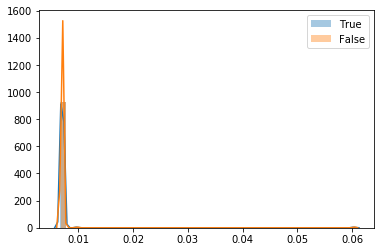

In [1726]:
sns.distplot(pred[true > 0.5], label="True")
sns.distplot(pred[true < 0.5], label="False")
plt.legend()
# plt.xlim(0, 0.02)

# Compare focal loss params

In [602]:
def np_focal_loss(y_true, y_pred, gamma, alpha):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    p1 = y_pred[(y_true > 0.5)]
    p0 = y_pred[(y_true < 0.5)]
    p1_mean = - np.sum(alpha * ((1 - p1) ** gamma) * np.log(p1))
    p0_mean = - np.sum((1 - alpha) * (p0 ** gamma) * np.log(1 - p0))
    return (p1_mean + p0_mean) / y_true.shape[0]

In [603]:
shape = 1000
y_true = (np.random.rand(shape) < 0.3).astype(float)
y_pred_1 = 0.5 * np.ones(y_true.shape)
y_pred_2 = 0.1 * np.ones(y_true.shape) # Should be greater than 1
y_pred_3 = 0.49 * np.ones(y_true.shape) + (y_true > 0.5) * (0.9 - 0.49) # Should be less than 1
y_pred_4 = 0.99 * np.ones(y_true.shape) # Should be greater than 1

In [604]:
gamma = 1
alpha = 0.5

In [605]:
np_focal_loss(y_true, y_pred_1, gamma=gamma, alpha=alpha)

0.17328679513998635

In [606]:
np_focal_loss(y_true, y_pred_2, gamma=gamma, alpha=alpha)

0.3279382440610576

In [607]:
np_focal_loss(y_true, y_pred_3, gamma=gamma, alpha=alpha)

0.11498288055263572

In [608]:
np_focal_loss(y_true, y_pred_4, gamma=gamma, alpha=alpha)

1.5660729280736512

# Prepare small MLP classifier

In [813]:
generator = iterate_chunks(data, events)

In [814]:
next(generator)
x, y = next(generator)

In [815]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

In [862]:
model = MLPClassifier(hidden_layer_sizes=(100, 100, 100, 100), solver="adam")

In [863]:
new_y = (np.squeeze(y).mean(axis=1) > 0.5)

In [864]:
new_y.sum() / new_y.shape[0]

0.375

In [865]:
new_x = x.reshape(32, 250 * 21)

In [866]:
model.fit(new_x, new_y)

/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100, 100, 100), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [867]:
model.score(new_x, new_y)

1.0

# Seq2seq

In [ ]:
feature_extractor = eeg_input

for cnn_filters in CNN_FILTERS:
    feature_extractor = keras.layers.Conv1D(cnn_filters, kernel_size=3, padding="same", activation="relu")(feature_extractor)
    feature_extractor = keras.layers.Conv1D(cnn_filters, kernel_size=3, padding="same", activation="relu")(feature_extractor)
    feature_extractor = keras.layers.MaxPool1D(pool_size=2, padding="same")(feature_extractor)

In [ ]:
encoder_outputs, encoder_h_state, encoder_c_state = keras.layers.LSTM(RNN_SIZE, stateful=True, return_state=True)(feature_extractor)

events_input = keras.layers.Input(batch_shape=(BATCH_SIZE, CHUNK_TIME, 1), name="events")

decoder_outputs, _, _ = keras.layers.LSTM(RNN_SIZE, return_sequences=True, return_state=True)(
    events_input, 
    initial_state=[encoder_h_state, encoder_c_state]
)
decoder_outputs = keras.layers.Dense(1, activation='sigmoid')(decoder_outputs)

model = keras.models.Model(inputs=[eeg_input, events_input], outputs=[decoder_outputs])

# One sequence

In [ ]:
# import tensorflow as tf
# from keras.layers import Dense,Activation,Dropout
# from keras.layers import LSTM,Bidirectional #could try TimeDistributed(Dense(...))
# from keras.models import Sequential, load_model
# from keras import optimizers,regularizers
# from keras.layers.normalization import BatchNormalization
# import keras.backend.tensorflow_backend as KTF

# model = Sequential()
# model.add(Dense(32,W_regularizer=regularizers.l2(l=0.01), batch_input_shape=(BATCH_SIZE, CHUNK_TIME // 2, len(CHANNELS))))
# model.add(Bidirectional(LSTM(32, return_sequences=True, stateful=True)))#, input_shape=(seqlength, features)) ) ### bidirectional ---><---
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(Dense(64, activation='relu',W_regularizer=regularizers.l2(l=0.01)))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(Dense(1, activation='sigmoid'))

In [ ]:
# def focal_loss(gamma=0, alpha=0.5):
#     def focal_loss_fixed(y_true, y_pred):
#         pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
#         pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
#         total_sum = - K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) 
#         total_sum -= K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
#         return 2 * total_sum / tf.cast(K.size(y_true), dtype=tf.float32)
#     return focal_loss_fixed